# Partie 3 : Optimisation of storage

### Table of Contents

* [1. Introduction](#1.introduction)
* [2. Adding storage to the operation problem](#storage)
    * [2.1. Math without efficiency](#without)
    * [2.2. With efficiency](#with)
    * [2.3. Modelisation](#model)
    * [2.4. Is a storage profitable ?](#profitable)

## 1. Introduction <a class="anchor" id="1.introduction"></a>
This document contains a description of storage operation and planing optimisation problem and how to solve them.

Objectives :
- Math : the mathematical formulation of storage operation can be modeled with linear programming, but the corresponding problem is still difficult to solve
- Python : learn to use a dynamic programing tool I implemented
- Economic : learn to estimate the value of storage in electricity market and dimension a storage

In [11]:
import numpy as np
import pandas as pd
import csv
import os
import datetime
import copy
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn import linear_model

os.chdir("D:\GIT\Etude_TP_CapaExpPlaning-Python")
from functions.functions_Operation import *
from functions.functions_Planing import *
from dynprogstorage.wrappers import GenCostFunctionFromMarketPrices
from dynprogstorage.Wrapper_dynprogstorage import Pycplfunction, Pycplfunctionvec

## 2. Adding storage to the operation problem <a class="anchor" id="storage"></a>
### 2.1. Math without efficiency <a class="anchor" id="without"></a>
Here x<sup>s</sup><sub>it</sub> is the power delivered (x<sup>s</sup><sub>it</sub>≥0) or consumed (x<sup>s</sup><sub>it</sub>≤0) by the storage.

\begin{align}
&\text{Cost function }& &\min_{x}  \sum_t \sum_i \pi_i x_{it}\;\;\; & & \pi_i \text{ marginal cost}\\ 
&\text{Power limit }   & &\text{ s.t.} \;\; 0 \leq x_{it}\leq a_{it} \bar{x_i} & &\bar{x_i} \text{ installed power, }  a_{it} \text{ availability}\\
&\text{Meet demand }   & & \sum_i x_{it} \geq  C_t  && C_t \text{ Consumption}\\
&\text{Stock limit }   & &\sum_t x_{it}\leq E_i && E_i=\bar{x_i}*N_i \text{ Energy capacity limit}\\
&\text{Storage Power limit }   & &\text{ s.t.} \;\; x^{s-}_{it} \leq x^s_{it}\leq x^{s+}_{it} & &x^{s-}_{it}<0,x^{s+}_{it}>0 \text{ installed/available power, }  \\
&\text{Storage Stock limit }   & & E_{it}^{s-}  \leq  E_{it}=E_0+\sum_{u=1}^t x^s_{iu}\leq E_{it}^{s+}  && E_{it}^-,E_{it}^+ \text{ capacity limit}\\
\end{align}

Most often there is one installed power P<sup>max</sup>=-x<sup>s-</sup><sub>it</sub>=x<sup>s+</sup><sub>it</sub>, and one capacity limit : E<sup>-</sup><sub>t</sub>=0, E<sup>+</sup><sub>t</sub>=C<sup>max</sup>. The stock limit E<sup>-</sup><sub>t</sub> (resp. E<sup>+</sup><sub>t</sub>) (in MWh) can be expressed in number of hours N<sup>-</sup><sub>t</sub>=E<sup>-</sup><sub>t</sub>/x<sup>s-</sup><sub>it</sub> (resp. N<sup>+</sup><sub>t</sub>=E<sup>+</sup><sub>t</sub>/xs<sup>s+</sup><sub>it</sub>) at full power.

### 2.2. With efficiency <a class="anchor" id="with"></a>
Q)3.1. How would you write the storage equations with an efficiency of α when consuming and β when producing ?

### 2.3 Modelisation <a class="anchor" id="model"></a>
The modelisation is a linear optimisation problem with a piecewise linear (concave) cost function.

In [4]:
nbTime=250
Prices=np.random.uniform(1, 1000, nbTime)
p_max=1.
c_max=10.*p_max

## x_i>0 : we stock (so we consume)
## x_i<0 : on produce
### --> phi_i(x_i) is a cost (purchase - sale) that we want to minimize
cpl_func = GenCostFunctionFromMarketPrices(Prices.tolist())
res = cpl_func.OptimMargInt([-p_max]*nbTime,[p_max]*nbTime,[0]*nbTime,[c_max]*nbTime)
print(res)

[0.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1

In [6]:
#revenue without efficiency
C=0
for i in range(len(Prices)):
    C=C+res[i]*Prices[i]
print(-C)

59225.17670756525


In [8]:
#revenue with efficiency (=0.8 here)
C=0
for i in range(len(Prices)):
    if res[i]>0:
        C=C+res[i]*Prices[i]/0.8
    elif res[i]<0:
        C=C+res[i]*Prices[i]*0.8
print(-C)

34214.12479709854


Here we see the money we could make if the storage was free

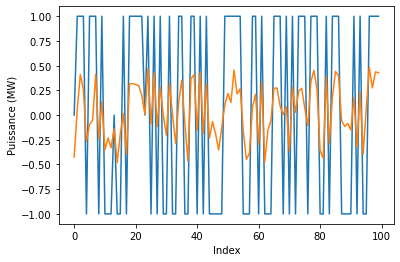

In [9]:
#courb
period=100
plt.plot(res[:100])
plt.plot(-(Prices[:100]-Prices.mean())/Prices.max())
plt.ylabel("Puissance (MW)")
plt.xlabel("Index")
plt.show()

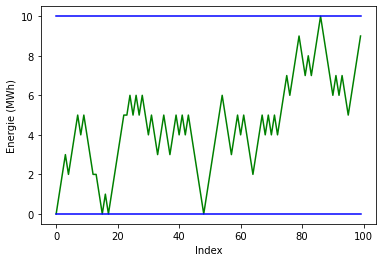

In [10]:
#courb
energie=np.cumsum(res)
plt.plot(energie[:100], color='g')
plt.plot([0]*100, color='b')
plt.plot([c_max]*100, color='b')
plt.ylabel("Energie (MWh)")
plt.xlabel("Index")
plt.show()

### 2.4 Is a storage profitable ? <a class="anchor" id="profitable"></a>

We do a planing simulation for the year 2013.

In [13]:
Zones="FR"
year=2013

Selected_TECHNOLOGIES={'Thermal', 'OldNuke'}

#### reading CSV files
areaConsumption = pd.read_csv('CSV/input/areaConsumption'+str(year)+'_'+str(Zones)+'.csv',
                                sep=',',decimal='.',skiprows=0)
availabilityFactor = pd.read_csv('CSV/input/availabilityFactor'+str(year)+'_'+str(Zones)+'.csv',
                                sep=',',decimal='.',skiprows=0)
TechParameters = pd.read_csv('CSV/input/Planing-Simple_TECHNOLOGIES.csv',sep=';',decimal=',',skiprows=0,comment="#")

#### Selection of subset
availabilityFactor=availabilityFactor[ availabilityFactor.TECHNOLOGIES.isin(Selected_TECHNOLOGIES)]
TechParameters=TechParameters[TechParameters.TECHNOLOGIES.isin(Selected_TECHNOLOGIES)]

model = GetElectricSystemModel_PlaningSingleNode(areaConsumption,availabilityFactor,TechParameters)
opt = SolverFactory('mosek')
results=opt.solve(model)
Variables=getVariables_panda(model)
Constraints= getConstraintsDual_panda(model)

Then we add a storage system on which you can modify the price (€/kWh). NB :The script is a bit long to run...

In [ ]:
prixBatterie=200 #€/kWh On peut changer le prix pour voir à partir de quel prix le stockage est rentable
P=[] #liste pour stocker le coût du système avec stockage
Pui=[] #liste pour stocker les différentes puissances de stockage
for i in range(25):
    PrixTotal={}
    Consommation={}
    LMultipliers={}
    DeltaPrix={}
    Deltazz={}
    CostFunction={}
    TotalCols={}
    zz={}
    #p_max_out=100.; p_max_in=100.; c_max=10.;
    p_max=i*100.;  c_max=4.*p_max;
    Pui.append(p_max)
    areaConsumption["NewConsumption"]=areaConsumption["areaConsumption"]
    nbTime=len(areaConsumption["areaConsumption"])
    cpt=0
    for i in model.areaConsumption:  model.areaConsumption[i]=areaConsumption.NewConsumption[i-1]
    for cpt in range(2):
        print(cpt)
        if (cpt==0): zz[cpt]=[0]*nbTime
        else : zz[cpt]=areaConsumption["Storage"]
        results=opt.solve(model)
        Constraints= getConstraintsDual_panda(model)
        TotalCols[cpt]=getVariables_panda(model)['energyCosts'].sum()[1]
        Prix=Constraints["energyCtr"].assign(Prix=lambda x: x.energyCtr *10**6).Prix.to_numpy()
        valueAtZero=Prix*(TotalCols[cpt]/sum(Prix*Prix)-zz[cpt])
        tmpCost=GenCostFunctionFromMarketPrices_dict(Prix,r_in=0.95,r_out=0.95,valueAtZero=valueAtZero)
        if (cpt==0): CostFunction[cpt]=GenCostFunctionFromMarketPrices(Prix,r_in=0.95,r_out=0.95,valueAtZero=valueAtZero)
        else:
            tmpCost = GenCostFunctionFromMarketPrices_dict(Prix, r_in=0.95, r_out=0.95, valueAtZero=valueAtZero)
            tmpCost2 = CostFunction[cpt-1]
            tmpCost2.Maxf_2Breaks_withO(tmpCost['S1'],tmpCost['S2'],tmpCost['B1'],tmpCost['B2'],tmpCost['f0']) ### etape clé, il faut bien comprendre ici l'utilisation du max de deux fonction de coût
            CostFunction[cpt]=tmpCost2
        LMultipliers[cpt]=Prix
        if cpt>0:
            DeltaPrix[cpt]=sum(abs(LMultipliers[cpt]-LMultipliers[cpt-1]))
            Deltazz[cpt]=sum(abs(zz[cpt]-zz[cpt-1]))
        areaConsumption["Storage"]=CostFunction[cpt].OptimMargInt([-p_max]*nbTime,[p_max]*nbTime,[0]*nbTime,[c_max]*nbTime)
        areaConsumption["NewConsumption"]=areaConsumption["areaConsumption"]+areaConsumption["Storage"]
        PrixTotal[cpt]=Prix.sum()
        Consommation[cpt]=areaConsumption.NewConsumption
        for i in model.areaConsumption:  model.areaConsumption[i]=areaConsumption.NewConsumption[i-1]
    cout=(areaConsumption['NewConsumption']*Prix*0.001).sum()
    P.append(cout)
fig=go.Figure()
fig.add_trace(
    go.Scatter(x=list(Pui), y=list(P), name="Dépenses"))
fig.update_layout(
    title_text="Dépenses en euros",xaxis_title="Puissance du stockage")
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                    label="en heures",
                    step="hour",
                    stepmode="backward")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="-"
    )
)
fig.show()

Q3.2) What is the minimal price for the storage system to be profitable ?